# AiiDA 
This implementation uses AiiDA to implement the equation of state workflow with Quantum ESPRESSO.
It intentionally provides a minimal implementation for the sake of simplicity:

* Quantum ESPRESSO is run locally, but could be run on a remote cluster
* Not all steps of the procedure are captured by provenance, just the Quantum ESPRESSO calculations
* The entire procedure is not yet wrapped up in a single workflow
* The SCF calculations are run serially but could be run in parallel

## Installation and setup
```
pip install aiida-core[atomic-tools]
pip install aiida-shell
verdi presto
```


In [1]:
from aiida import load_profile

load_profile()

Profile<uuid='40b1c0b67d08458299c7057ec91dea76' name='presto'>

## Implementation of a new simulation code

AiiDA allows developers to implement complex interfaces for any external code, with features such as input validation, error handling etc.
However, if you just want to run an external code without too much faff, you can use `aiida-shell` to do so.

In [2]:
from pathlib import Path

from ase.build import bulk
from aiida.orm import SinglefileData

from functions import write_input

FILEPATH_PSEUDOS = Path.cwd() / 'espresso' / 'pseudo'
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

input_string = write_input(
    input_dict={
        "structure": bulk('Al'), 
        "pseudopotentials": pseudopotentials, 
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
        },
    return_string=True
)

Although the `pw.x` executable can be run without any parsing, let's add a parser that converts the outputs into AiiDA nodes to improve the richness of the provenance:

In [3]:
from aiida import orm
from adis_tools.parsers import parse_pw

def pw_parser(dirpath):
    
    parsed_data = parse_pw(dirpath / 'pwscf.xml')

    return {
        'structure': orm.StructureData(ase=parsed_data['ase_structure']),
        'energy': orm.Float(parsed_data['energy']),
        'volume': orm.Float(parsed_data['ase_structure'].get_volume()),
    }

Now it's time to run the relaxation:

In [4]:
from aiida_shell import launch_shell_job

results_relax, node_relax = launch_shell_job(
    'pw.x',
    arguments='-in {input_file}',
    parser=pw_parser,
    nodes={
        'input_file': SinglefileData.from_string(input_string, filename='input.pwi'),
    },
    outputs=['pwscf.xml', ],
    metadata={
        'options': {
            'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}',
            'redirect_stderr': True
        }
    }
)

## EOS

In [5]:
from functions import generate_structures

scaled_structures = generate_structures(
    results_relax['structure'].get_ase(), [0.9, 0.95, 1.0, 1.05, 1.1])

structures = []
energies = []

scf_inputs = {
    "pseudopotentials": pseudopotentials, 
    "kpts": (3, 3, 3),
    "calculation": "scf",
    "smearing": 0.02,
}

for scaled_structure in scaled_structures:

    scf_inputs['structure'] = scaled_structure
    input_string = write_input(scf_inputs, return_string=True)

    results_scf, node_scf = launch_shell_job(
        'pw.x',
        arguments='-in {input_file}',
        parser=pw_parser,
        nodes={
            'input_file': SinglefileData.from_string(input_string, filename='input.pwi'),
        },
        outputs=['pwscf.xml', ],
        metadata={
            'options': {
                'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}',
                'redirect_stderr': True
            }
        }
    )

    structures.append(results_scf['structure'].get_ase())
    energies.append(results_scf['energy'].value)

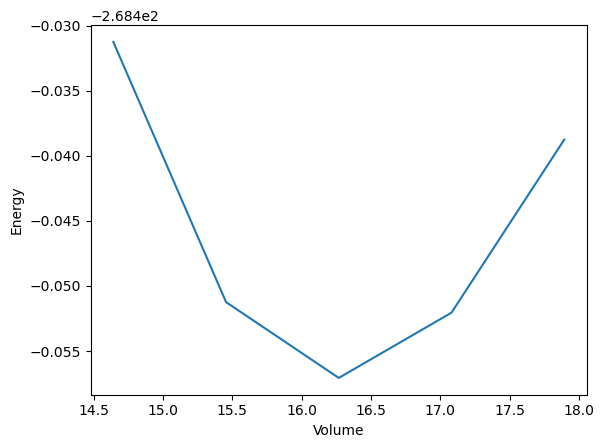

In [6]:
import matplotlib.pyplot as plt
volumes = [structure.get_volume() for structure in structures]

plt.plot(volumes, energies)
plt.xlabel('Volume')
plt.ylabel('Energy')
plt.savefig('evcurve.png')

## Submission to HPC - up-scaling for high throughput screening 

AiiDA allows registering remote HPC compute resources in its database, which can then be used for submitting simulations. Registration can be achieved via the CLI with `verdi computer setup`, followed by `verdi computer configure`, or via the Python API (see below). With the first command, the database entry for the `Computer` is created (and the provided information immutably stored in the DB), while the second command _configures_ the compute resource, which are, among others, the SSH connection parameters.

AiiDA provides interfaces for various _transport technologies_, most notably SSH, implemented, as well as the most common schedulers, such as SLURM or SGE. This means that after successful registration in the database, using such HPC resources is as simple as changing a single string in the submission script that specifies the computer where the calculation should be run. When a simulation is started, AiiDA takes care to communicate with the HPC and upload all required files, as well as generate the submission script. In addition to the remote compute resource, also the codes (executables) have to be registered to such that they can then be used to run simulations.

One advantage of this design, among others, is the fact that utilizing different HPCs, even within one workflow, can be easily achieved by using the corresponding identifiers of the compute resources. In addition, the software environment does _not_ have to be duplicated on the HPC, but AiiDA instead runs locally. However, this means that compute resources first have to be correctly registered in AiiDA, which can present an initial barrier for new users. The following code snippets show how a computer and a code can be registered via the Python API:

```python
# The `get_or_create` method allows keeping the `Computer` generation atomic within this notebook
from aiida import orm

created, computer = orm.Computer.collection.get_or_create(
    label="Todi",
    description="New Todi HPC at CSCS",
    hostname="todi",
    workdir="/scratch/<user>/aiida",
    transport_type="core.ssh",
    scheduler_type="core.slurm",
)

if created:
    computer.store()
    computer.set_minimum_job_poll_interval(10.0)
    computer.set_default_mpiprocs_per_machine(128)
    computer.set_append_text('')
    computer.set_prepend_text('')
    computer.configure()

print(computer)
```

```python
# Register a code for later use 
try:
    code = aiida.orm.load_code("pw.x@todi")
except aiida.common.NotExistent:
    code = aiida.orm.Code(
        computer=load_computer('todi'),
        remote_computer_exec=[computer, data.pwx_path],
    )
    code.label = "pw.x"
    code.description = "Quantum ESPRESSO pw.x code"
    code.set_prepend_text("export OMP_NUM_THREADS=1")
    code.store()
code
```

```python
# For `aiida-shell` the computer can directly be passed to the metadata options of the simulation
# This is because the executable is directly passed as the first argument to the `launch_shell_job` function
# And the path is resolved internally and a `Code` entity created
metadata={
        'options': {
            'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}',
            'redirect_stderr': True
            'computer': load_computer('<my-hpc-resorce>'),
            }
        }
```

## Cache Workflow Steps

AiiDA provides caching functionality out of the box. 
By default, caching is turned off, however, it can be globally enabled via the CLI with the command:
`verdi config set caching.default_enabled True` 
as well as for individual simulation types with, e.g.
`verdi config set caching.enabled_for aiida.calculations:quantumespresso.pw`.

To achieve this, all nodes are automatically hashed, and the hashes saved in the _extras_ of the respective Nodes once they are stored in the database:
```python
from aiida import orm
node = orm.Int(1)
node.store()

print(node.base.caching.get_hash())
```

Caching is then made possible by comparing the hashes of the `ProcessNode` of a given simulation that is to be executed, including all its input `Data` nodes, and comparing those with the existing entries in the DB. If the exact same simulation has already been carried out successfully, the corresponding nodes are duplicated and inserted into the workflow, rather than running the same simulation again. While this saves computational time, it does not necessarily save space, due to the duplication of data.

There are a few details to keep in mind for caching, because, as the saying goes _"There are only two hard things in Computer Science: cache invalidation and naming things."_ For one, a choice has to be made which data should be included when calculating the hash. E.g., which input nodes should be considered for calculating the hash of a Process? Or to which precision should the AiiDA, as well as the plugin version be included for evaluating the hash? We can assume that results between different major versions actually _are_ different, but what about minor and patch versions? Overall, a balance has to be found between minimizing the chance of false negatives, where two nodes should have the same hash but do not, and false positives, where two different nodes get the same hash by mistake. For instance, if every patch version would lead to different hashes, despite the fact that results can be expected to be the same, the feature would not be very useful. Furthermore, it is not immediately clear how far a workflow should be traced to generate the hash of a given Data node that it produced.

## Keep Track of the Execution

As provenance is one of the principal features behind AiiDA, great care has been taken during its development to ensure that the execution of a workflow is being tracked and that data can always be traced back. In addition, AiiDA implements checkpointing, meaning that each successful step completed during the execution of a workflow is recorded in the database. This allows restarting a running workflow, even after the workstation that runs AiiDA has been shut down or an SSH connection to an HPC has dropped.

## Data Organisation

AiiDA stores data in an SQL database, as well as an internal file repository. The former is used for input/parsed output Data nodes of well-defined types, such as `str` or `int` (using the corresponding AiiDA data types), while raw files are stored in the file repository (as they are often too large to store the contents in the SQL database).

To organize data, AiiDA provides the concepts of _Groups_ that can be used to create collections of specific data nodes, such as, for example, all crystal structures used for a study, or all band structure simulations (but groups with mixed types are of course possible). As AiiDA further stores plenty of useful metadata (such as the creation and last modification time), one can easily query and/or filter data even years after its creation. Without a computational infrastructure like AiiDA, it can be otherwise difficult to navigate files and folders. Of course, also with AiiDA, proper organization using groups, and, possibly, adding additional metadata to the Nodes is just as helpful as keeping a logical directory structure when working with files and folders.

## Sharing Workflows

Lastly, once all required simulations have been conducted AiiDA, thus concluding a research project, all data can be exported using the `verdi archive create` CLI endpoint. Here, collections of data nodes, groups, or  other entities can be selected for exporting (in addition to _all_ profile data). These archives can then be shared with other researchers, who can import them into their AiiDA profiles.

While the data of a concrete, executed workflow is contained in the exported archives, the workflow logic cannot be shared in the same way. Instead, however, it is defined by the Python source code that was used to set up the workflow. These workflows are usually grouped together (with other required code infrastructure), in AiiDA-plugins, of which an extensive collection is available to the general public in the [AiiDA plugin registry](https://aiidateam.github.io/aiida-registry/).